# RNN Ludvig Van Beethoven

This is the second notebook where the second solution is displayed, We strongly suggest you read this after reading the one referencing Bach. The goal of this notebook is to showcase a different solution to the music classification problem using a recurrent neural network that we named in the name of the great compositor Beethoven. As I said this notebook will be a bit lighter in text since most of it has already been done in the previous one.



## Dependencies

Nothing out of the ordinary, librosa is the main library to preprocess .wav files and get vectors that we can process.

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

#KERAS
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import recurrent, Conv1D, MaxPooling1D
from keras.layers.core import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import to_categorical
from tensorflow import keras

#PLOTTING
import matplotlib.pyplot as plt

#DATA
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


# Preprocessing

The first step is to access the .wav files. Each file is in a folder with the label of the genre so we will have to iterate through these folders, we will use 'os' for this and to check if it is a directory since we only want to move into the folders and into any other to or file.

## Wave to vector

We used librosa’s load module to get the data with a sample rate of 22050.

## Formatting the data

As it is to be expected not all the files gave vectors of the same size, we made a preliminary analysis of this and concluded to cut them short at 660000 numbers since this would mean we normalize the data shape and lose barely any information from the music. Once the data has been reduced to the same size, it is time to start making splits. 

First, each .wav will be split into 100 segments making each segment around 0.3 seconds long and then reshaping into a 2 dimensional array of shape (60,100). We will also use this 60 as our lookback. This rises up some questions, "is it possible to detect the genre of a song from only 0.3 seconds?" Yes, it is not easy but with the right amount of data dropout and the correct data format it's possible.

## Classes

We decided to use One Hot Encoding as the data format for our classes. These arrays are made at the same time the data is being formatted. since the data is in order we just have to change the index we put as 1 every X examples.

In [5]:
def load_audio(filename, sample_rate=22050, dtype=np.float32) -> np.ndarray:
    
    dtype = np.dtype(dtype)
    wave, sr = librosa.load(filename, sr=sample_rate, mono=True, dtype=dtype)
    return wave, sr


def gather_data(path):

    music = []
    for dir0 in os.listdir(path):
        
        full_path=os.path.join(path, dir0) 
        
        if os.path.isdir(full_path):
            print(dir0)
            
            for file in os.listdir(full_path):
                
                music_path=os.path.join(full_path, file)
                y, _ = load_audio(music_path) 
                music.append(y)
            
    return np.array(music)  

#a = gather_data("./genres")

def gather_data_test(path):

    music = []
        
    for file in os.listdir(path):
            
        music_path=os.path.join(path, file)
        y, _ = load_audio(music_path) 
        music.append(y)
            
    return np.array(music)  


def format_data_test(data):
    splitedData = []
    classes = []
    n = 0
    
    mod = []
    for i in data:
        i = i[:660000]
        a = np.split(i,100)
        for j in a:
            mod.append(j)
    mod = np.array(mod)
    for i in range(mod.shape[0]):
        ohe = np.zeros(10)
        if i % 500 == 0 and i != 0:
            n +=1
        wav = mod[i]
        wavList = np.split(wav, 60)
        splitedData.append(wavList)
        ohe[n] = 1
        classes.append(ohe)
    return np.array(splitedData), np.array(classes)    

def format_data(data):
    splitedData = []
    classes = []
    n = 0
    
    mod = []
    for i in data:
        i = i[:660000]
        a = np.split(i,100)
        for j in a:
            mod.append(j)
    mod = np.array(mod)
    for i in range(mod.shape[0]):
        ohe = np.zeros(10)
        if i % 9500 == 0 and i != 0:
            n +=1
        wav = mod[i]
        wavList = np.split(wav, 60)
        splitedData.append(wavList)
        ohe[n] = 1
        classes.append(ohe)
    return np.array(splitedData), np.array(classes)


def get_batch(data,classes, batch_size = 100):
   indices = np.random.permutation(data.shape[0])[0:batch_size]
   return data[indices] , classes[indices]

## Readying the data

Once again we decided to use the train_test_split for convenience. The validation portion has to be small in order to feed enough information to the Bach to learn segments of 0.3s.

In [6]:
data = gather_data("./genres")
X, Y = format_data(data)
train_data, valid_data, train_target, valid_target = train_test_split(X,Y, test_size= 0.1, random_state=31 )
print(X.shape, Y.shape)
X[:5]


blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock
(95000, 60, 110) (95000, 10)


array([[[ 0.00732422,  0.01660156,  0.00762939, ..., -0.02276611,
         -0.01895142, -0.0324707 ],
        [-0.03466797, -0.02368164, -0.02191162, ...,  0.00582886,
          0.00335693,  0.00500488],
        [ 0.00350952, -0.0083313 , -0.01715088, ...,  0.0118103 ,
          0.01583862,  0.02597046],
        ...,
        [ 0.09518433,  0.06594849,  0.06161499, ...,  0.00274658,
          0.0267334 ,  0.07174683],
        [ 0.12466431,  0.14938354,  0.13220215, ...,  0.20077515,
          0.17285156,  0.12713623],
        [ 0.10879517,  0.1083374 ,  0.1171875 , ...,  0.00588989,
          0.07333374,  0.09622192]],

       [[ 0.07980347,  0.04382324,  0.00305176, ...,  0.0619812 ,
          0.10171509,  0.16955566],
        [ 0.23937988,  0.28430176,  0.31167603, ..., -0.23608398,
         -0.23855591, -0.2866211 ],
        [-0.3368225 , -0.33807373, -0.28393555, ...,  0.09066772,
          0.11801147,  0.11911011],
        ...,
        [ 0.01901245,  0.04779053,  0.0526123 , ..., -

# RNN parameters

We will define the parameters of the RNN. We will train with 100 cells in each LSTM layer. The look back will be the first dimension. And we will train for 175 epochs.

In [7]:

#PARAMS
number_cells = 100
look_back = 60
batch_size = 100
epochs = 175


# Ludwig Van Beethoven

## Cells

We will use the LSTM cell available in keras since it works really well at analyzing sequences which is precisely what music is. We used 3 layers of fully connected LSTM cells, 100 in each layer. It is important to note that in order to get this to work you will need the return_sequences as true if the next layer is also an LSTM.

## Activation

We only use an activation function in the last layer, which is the same, softmax.

## Dropout

Dropout is key, without it the model learns the training set in less than a 100 epochs since it is very small, leaving the validation set at a mere 30% accuracy. Implementing dropout at each layer with a little emphasis for the last one proved to be the best way of having the validation data and the training data progress at the same rate.




In [8]:

#MODEL LSTM
Ludwig_van_Beethoven = Sequential ()
Ludwig_van_Beethoven.add(LSTM(number_cells,return_sequences=True, input_shape =(look_back, 110) ))
Ludwig_van_Beethoven.add(Dropout(0.3))
Ludwig_van_Beethoven.add(LSTM(number_cells,return_sequences=True))
Ludwig_van_Beethoven.add(Dropout(0.2))
Ludwig_van_Beethoven.add(LSTM(number_cells))
Ludwig_van_Beethoven.add(Dropout(0.3))
Ludwig_van_Beethoven.add (Dense (10,activation = 'softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
Ludwig_van_Beethoven.compile (loss ="categorical_crossentropy", metrics = ["categorical_crossentropy"] , optimizer = opt)   

Ludwig_van_Beethoven.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           84400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

# Training

This cell can be used to train the model 175 epochs are enough to get decent accuracy but to get to the point of our model 400+ epochs are necessary. Please note this took several hours so train at your own risk. A strong GPU is suggested.

In [7]:
history = Ludwig_van_Beethoven.fit(train_data, train_target, batch_size= 100, epochs= epochs, validation_data=(valid_data,valid_target))
Ludwig_van_Beethoven.save("Beethoven_new.h5")

- 43s 506us/sample - loss: 1.1178 - categorical_crossentropy: 1.1178 - val_loss: 1.2135 - val_categorical_crossentropy: 1.2135
Epoch 71/177
85500/85500 [==============================] - 43s 508us/sample - loss: 1.1121 - categorical_crossentropy: 1.1121 - val_loss: 1.2301 - val_categorical_crossentropy: 1.2301
Epoch 72/177
85500/85500 [==============================] - 44s 509us/sample - loss: 1.1043 - categorical_crossentropy: 1.1043 - val_loss: 1.2095 - val_categorical_crossentropy: 1.2095
Epoch 73/177
85500/85500 [==============================] - 43s 506us/sample - loss: 1.1021 - categorical_crossentropy: 1.1021 - val_loss: 1.2044 - val_categorical_crossentropy: 1.2044
Epoch 74/177
85500/85500 [==============================] - 43s 506us/sample - loss: 1.0939 - categorical_crossentropy: 1.0939 - val_loss: 1.1945 - val_categorical_crossentropy: 1.1945
Epoch 75/177
85500/85500 [==============================] - 43s 500us/sample - loss: 1.0867 - categorical_crossentropy: 1.0867 - val_

# Losses

We used the categorical crossentropy loss function for obvious reasons and as can be seen below at around 70 epochs the loss starts plateauing but if you let it run for another 105 epochs you approach  the 0.9 mark ever so slowly. One very important thing to note is that this loss function even if it is the one that works best for this scenario is deceiving, compared  to the 0.2 result of Bach it looks way worse but when that is mainly because of the continuous characteristic of the LSTMs. Same for accuracy the reason it is not displayed it's because it shows as 0. However if you compute the accuracy manually it shows great results.


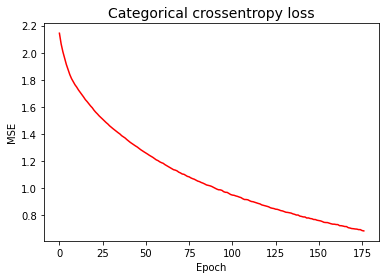

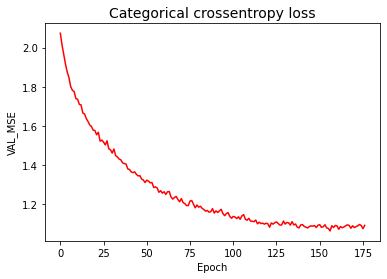

In [14]:
plt.title("Categorical crossentropy loss", fontsize=14)
plt.plot(history.history["categorical_crossentropy"],'r-')
plt.xlabel("Epoch")
plt.ylabel("categorical_crossentropy")
plt.show()

plt.title("Categorical crossentropy loss", fontsize=14)
plt.plot(history.history["val_categorical_crossentropy"],'r-')
plt.xlabel("Epoch")
plt.ylabel("VAL_categorical_crossentropy")
plt.show()

# Testing

This is where those previously mentioned 50 files come into play. The validation part was used to let Beethoven get as much info to learn the patterns in 0.3s of information. This means that validation data can not really be trusted and this is why we are going to use these files. Since these files have never been imputed to Beethoven we will see how accurate the RNN really is.

In [9]:
test = gather_data_test("./test")
test_data, test_target = format_data_test(test)

print(test_data.shape, test_target.shape)

(5000, 60, 110) (5000, 10)


## Accuracy

In order to get the real accuracy we need to compare the index with the highest number of the predicted vector with the index corresponding to the one of the target. As we can see the results are better than the loss function suggests.

In [16]:
Ludwig_van_Beethoven = keras.models.load_model('Beethoven.h5')

num = 100
test = test_data
k = test_target
a = Ludwig_van_Beethoven.predict(test)
cont = 0
for i in range(test_data.shape[0]):
    b = np.where(k[i] == k[i].max())
    c = np.where(a[i] == a[i].max())
    if b == c:
        cont += 1
print("The accuracy of Beethoven is:",cont/test_data.shape[0])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The accuracy of Beethoven is: 0.8344


# Final results

Since the accuracy is not displayed in the metrics because it never predicts an exact one we can only look at the loss here but it is apparent that even with the files that Beethoven has never seen it performs admirably well. If we look at the accuracy the way we calculated up above we can see the results in test are also really good. 

But this is not the end of it. Let's go back to the beginning. Our wav files have a length of 30 second which means we can extract 100 0.3s segments. Now let's input all these segments into Beethoven. Let's do a small statistical analysis of the chances of getting the wrong answer. Let's assume every class has the same chance of being selected between the ones that are wrong. Meaning every wrong class hacs 0.18/9 chance of being predicted individually. The least amount of times a class needs to me predicted to have a majority is 11 since there are 10 classes meaning the highest chance of getting the wrong classification on a 30s audio is => (0.18/9)^11 = 2.048e-19. Obviously these are incredible results and the best part is we can get ~1 accuracy while avoiding overfitting thanks to predicting segment by segment. Obviously these only happen if each genre was learnt exactly the same as the other and the song didn't vary that much. In practice we will see some songs are harder than others to predict because of their unique flavours.

In [19]:
Ludwig_van_Beethoven_train_error = Ludwig_van_Beethoven.evaluate(train_data, train_target, batch_size=batch_size)
Ludwig_van_Beethoven_valid_error = Ludwig_van_Beethoven.evaluate(valid_data, valid_target, batch_size=batch_size)
Ludwig_van_Beethoven_test_error = Ludwig_van_Beethoven.evaluate(test_data, test_target, batch_size=batch_size)

print("Beethoven train error:", Ludwig_van_Beethoven_train_error[0])
print("Beethoven valid error:", Ludwig_van_Beethoven_valid_error[0])
print("Beethoven test error:", Ludwig_van_Beethoven_test_error[0])



Beethoven train error: [0.5372288075804014, 0.53722864]
Beethoven valid error: [0.5434039426477332, 0.5434039]
Beethoven test error: [0.5209136285074055, 0.52091366]
